In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing
import itertools
import torch

from sklearn import preprocessing

from dynamics.duffing import dynamics_duff
from dynamics.Vanpol import dynamics_vanpol
from dynamics.lorentz import dynamics_lorenz
from utils import sprandsym

from core.reservoir_comp import train_reservior, validate_reservoir, data_prep

import scipy.io
import scipy.sparse

In [2]:
# Base Parameters
dt = 0.005 #time step
num_snaps = 2000 # no. of snapshots
T = np.linspace(0,num_snaps*dt, num_snaps+1)
num_train = 100 # no. of training examples
num_val = int(0.25*num_train) # no of testing examples
num_traj = num_train+num_val #no of trajectories

In [3]:
# # Oscillator parameters for duffing
system = "Duffing"

In [4]:
dyn_pars = {}
if system=="Duffing":
    num_states = 2
    num_inputs = 1

    dyn_pars['a'] = -1
    dyn_pars['b'] = 1
    dyn_pars['c'] = 0.2
    dyn_pars['d'] = 0.3

    dyn_pars['del_a'] = -1.5
    dyn_pars['del_b'] = 1.5
    dyn_pars['del_c'] = 0.3
    dyn_pars['del_d'] = 0.2
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

elif system == "Vander":
    # Oscillator parameters for Van Der pol Oscillator
    num_states = 2
    num_inputs = 1
    mu = 2

    dyn_pars['a'] = 1
    dyn_pars['b'] = mu
    dyn_pars['c'] = 0.5
    dyn_pars['d'] = mu

    dyn_pars['del_a'] = dyn_pars['a']*percent_change/100
    dyn_pars['del_b'] = dyn_pars['b']*percent_change/100
    dyn_pars['del_c'] = dyn_pars['c']*percent_change/100
    dyn_pars['del_d'] = dyn_pars['d']*percent_change/100
    dyn_pars['delay'] = False
    dyn_pars['delay_time'] = 5
    dyn_pars['cont_unc_type'] = 'sinusoidal'

In [5]:
if system =="Duffing":
    X_changed, X_unchanged, U = dynamics_duff(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)
elif system=="Vander":
    X_changed, X_unchanged, U = dynamics_vanpol(dt, num_traj, num_snaps, num_states, num_inputs, dyn_pars)

print(X_changed.shape, U.shape)

(125, 2001, 2) (125, 2000, 1)


In [6]:
# Check for nan values
print(sum(sum(sum(np.isnan(X_changed)))))
print(sum(sum(sum(np.isnan(X_unchanged)))))

0
0


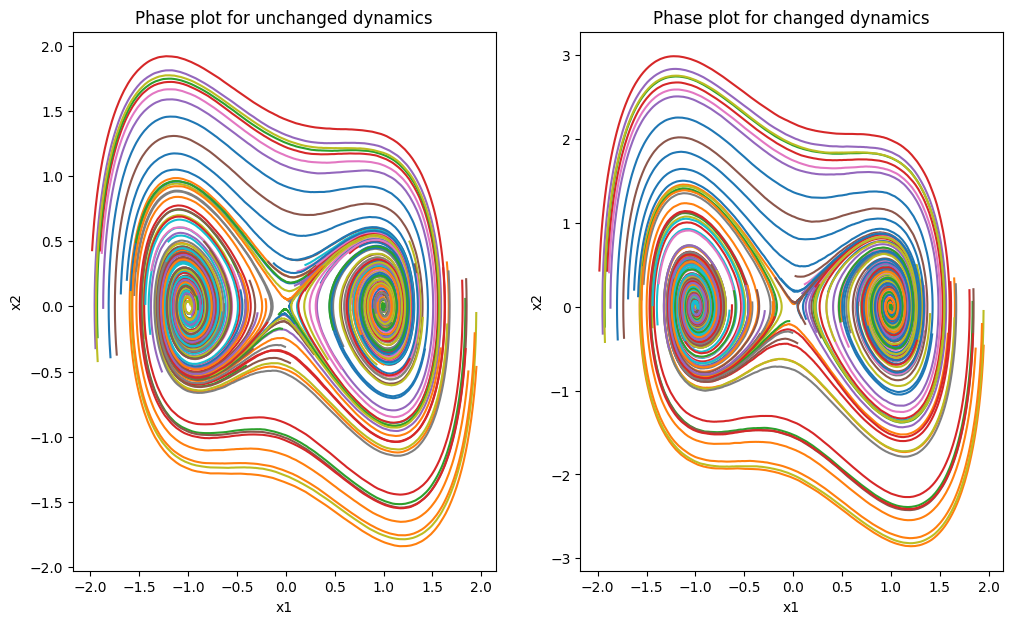

In [7]:
# plot dataset
fig, axs = plt.subplots(1,2,figsize=(12,7))
axs[0].set_title("Phase plot for unchanged dynamics")
axs[1].set_title("Phase plot for changed dynamics")

axs[0].set(xlabel = 'x1', ylabel = 'x2')
axs[1].set(xlabel = 'x1', ylabel = 'x2')

for i in range(num_traj):
    axs[0].plot(X_unchanged[i,:,0], X_unchanged[i,:,1])
    axs[1].plot(X_changed[i,:,0], X_changed[i,:,1])


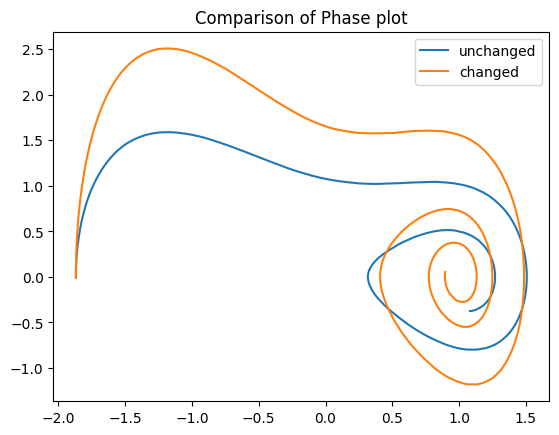

In [8]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.show()

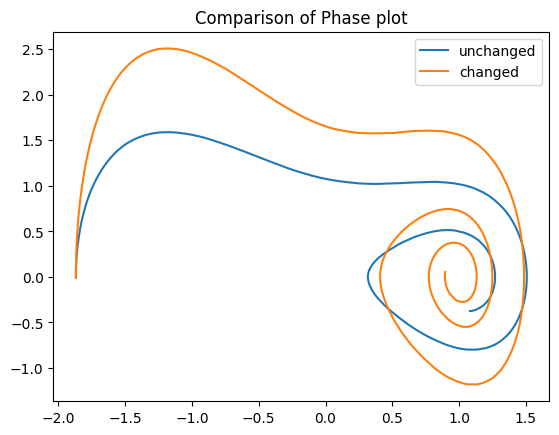

In [9]:
plt.figure()

plt.title('Comparison of Phase plot')
plt.plot(X_unchanged[4,:,0], X_unchanged[4,:,1], label = 'unchanged')
plt.plot(X_changed[4,:,0], X_changed[4,:,1], label = 'changed')

plt.legend()
plt.show()

In [10]:
xs_train, us_train = X_unchanged[:num_train,:,:],U[:num_train,:,:]
xs_val, us_val = X_unchanged[num_train:,:,:],U[num_train:,:,:]

In [11]:
params = {}
if system =="Duffing":
    params['alpha'] = 1;
    params['beta'] = 0.04;
    params['gamma'] = 1;
    params['delta'] = 0.1
elif system=="Vander":
    params['mu'] = 1;
    params['A'] = 0.04;

In [12]:
system_info ={}
system_info['dim_in'] = 2*num_states
system_info['dim_out'] = num_inputs
system_info['num_states'] = int(num_states/2)
system_info['num_inputs'] = num_inputs


In [13]:
bias = 0;
n = 100;
hyperpara_set = [0.756250, 0.756250, 0.843750, -3.125, 106.71875, bias];
eig_rho = hyperpara_set[0];
W_in_a = hyperpara_set[1];
alpha = hyperpara_set[2];
beta = 10**hyperpara_set[3];
k = round(hyperpara_set[4]/200*n);
kb = hyperpara_set[5];

In [14]:
W_in = W_in_a*(2*np.random.rand(n,system_info['dim_in'])-1);
res_net = sprandsym(n,k/n);
eig_D,_ = scipy.sparse.linalg.eigs(res_net,1);
eig_D = eig_D[0]
res_net = (eig_rho/(abs(eig_D)))*res_net;
res_net = res_net.toarray()

In [15]:
res_info = {}
res_info['W_in'] = W_in
res_info['res_net'] = res_net
res_info['alpha'] = alpha
res_info['beta'] = beta
res_info['kb'] = kb
res_info['n'] = n


In [16]:
data_info = {}
data_info['dt'] = dt
data_info['num_traj'] = num_traj
data_info['num_snaps'] = num_snaps
data_info['num_train'] = num_train
data_info['total_datapoints'] = num_traj*num_snaps


In [17]:
data_train = {}
data_train['x'] = xs_train
data_train['u'] = us_train
data_train['num_traj'] = num_train

data_val = {}
data_val['x'] = xs_val
data_val['u'] = us_val
data_val['num_traj'] = num_val

In [18]:
train = True
update_train_matricies = False
file_path = 'saved_models/reservior_comp/'+system + '/'

if train:
    Wout, r_end = train_reservior(data_train,data_info,res_info,system_info)

In [19]:
control_info = validate_reservoir(data_info, data_val, res_info, Wout, r_end, system_info)

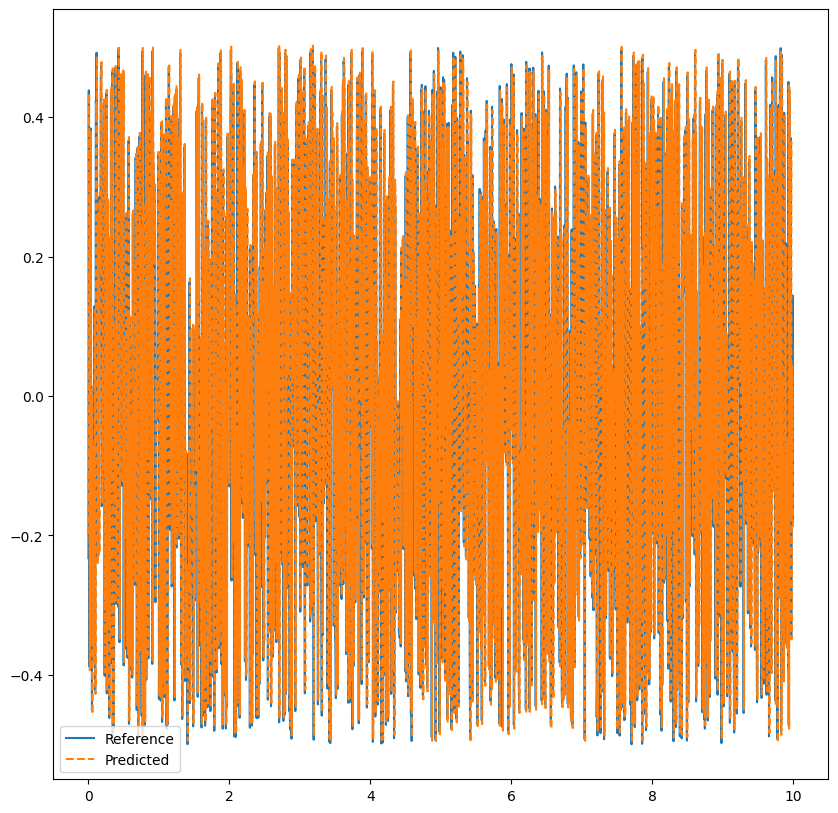

In [20]:
t_val = np.linspace(0,num_snaps*dt,num_snaps+1)
plt.figure(figsize=(10,10))
plt.plot(t_val[:-1],control_info['u_val_flat'][:num_snaps], label = 'Reference')
plt.plot(t_val[:-1],control_info['u_pred'][:num_snaps],'--', label = 'Predicted')
plt.legend()